## Содержание:
* [Стационарность](#stacionary)
* [Преобразование Бокса-Кокса](#boxcox)
* [Модели для предсказания значений временного ряда](#predict)
* [Метрики точности прогноза](#metrics)

Импортируем библиотеки

In [1]:
# Импортируем необходимые библиотеки

import os
from os import path
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.tsa.api as smt

Рутина с датасетами

In [2]:
# аналогичным образом загружаем данные о пассажирах
passengers = pd.read_csv('data/Annual snowfall in Buffalo 19101972.csv')
# неподходящий формат данных приводим к тому, с которым Pandas может работать
# также устанавливаем индекс и сортируем
df = passengers.set_index('year number').sort_index()

In [6]:
df.describe()

,x
count,63.000000
mean,80.295238
std,23.719812
min,25.000000
25%,64.500000
50%,79.600000
75%,97.650000
max,126.400000


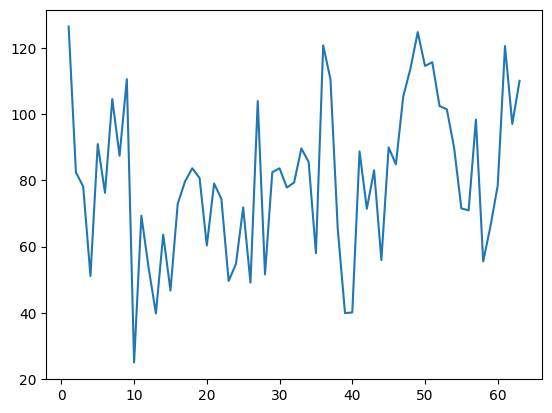

In [7]:
plt.plot(df) # рисуем ряд

In [8]:
from statsmodels.tsa.stattools import adfuller

In [9]:
def check_stationary(ts, series_name : str): # тест Дики-Фуллера проверки ряда на стационарность
    alpha = 0.05
    name = series_name


    print(f'Тест Дики-Фуллера ряда {name} :')
    # определяем результат значения теста из библиотеки с учетом
    dftest = adfuller(ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

    if dfoutput["p-value"] < alpha:
        print(f"Значение p меньше {alpha * 100}%. Ряд стационарный.")
    else:
        print(f"Значение p больше {alpha*100}%. Ряд не стационарный.")

In [11]:
check_stationary(df, 'Ежегодный снегопад') # видим, что наш ряд стационарен

Тест Дики-Фуллера ряда Ежегодный снегопад :
Test Statistic                -5.718539e+00
p-value                        7.028398e-07
#Lags Used                     0.000000e+00
Number of Observations Used    6.200000e+01
Critical Value (1%)           -3.540523e+00
Critical Value (5%)           -2.909427e+00
Critical Value (10%)          -2.592314e+00
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


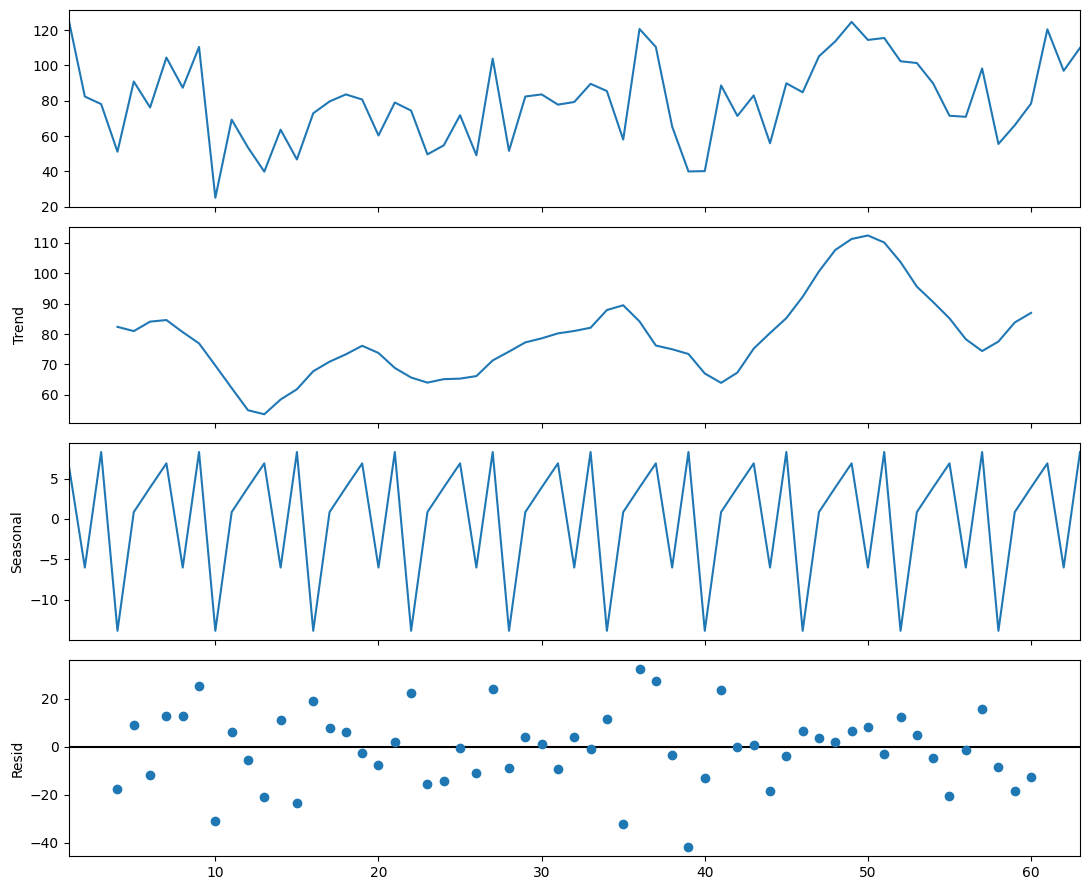

In [12]:
# декомпозиция ряда
from statsmodels.tsa.seasonal import seasonal_decompose

# задаем размер графика
from pylab import rcParams
rcParams['figure.figsize'] = 11, 9

decompose = seasonal_decompose(df, 
                               period=6)
decompose.plot()
plt.show()

In [19]:
df['x'][1]

126.4

In [23]:
# удаляем тренд и сезонность
nottrend = []
s = 6
notseason = []

# выборка без тренда
for i in range(2, len(df)):
   nottrend.append(df['x'][i] - df['x'][i-1])

# выборка без сезонности
for i in range(s + 1, len(df)):
   notseason.append(df['x'][i] - df['x'][i-s])


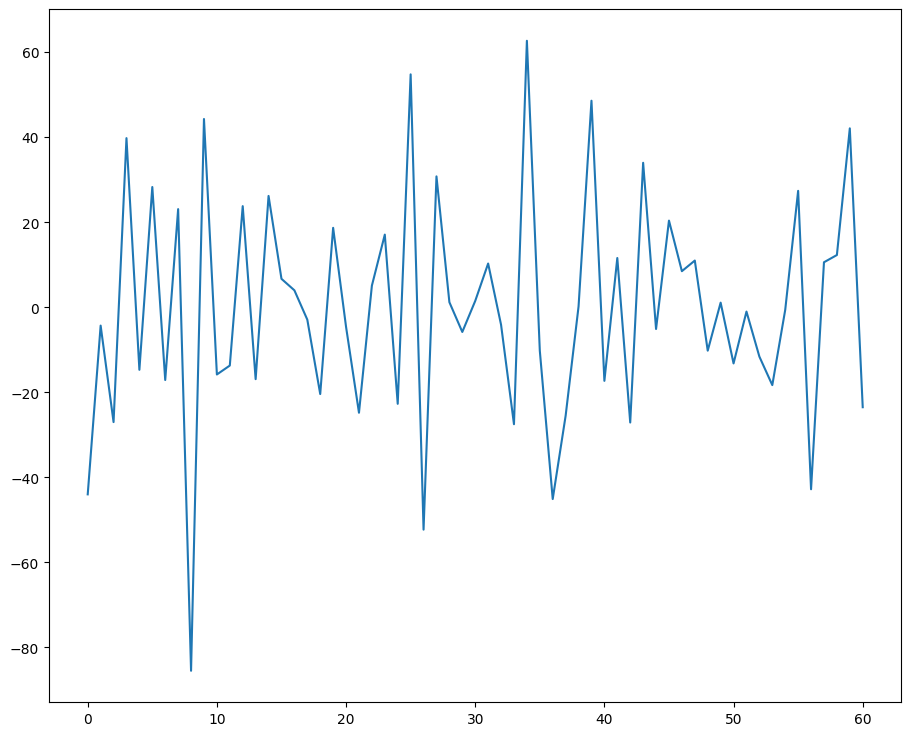

In [21]:
# ряд без тренда
plt.plot(nottrend)

Теперь проведем тест Дики-Фуллера на временном ряде без тренда

In [24]:
# проверяем ряд без тренда на стационарность

check_stationary(df, 'Снегопад без тренда')

Тест Дики-Фуллера ряда Снегопад без тренда :
Test Statistic                -5.718539e+00
p-value                        7.028398e-07
#Lags Used                     0.000000e+00
Number of Observations Used    6.200000e+01
Critical Value (1%)           -3.540523e+00
Critical Value (5%)           -2.909427e+00
Critical Value (10%)          -2.592314e+00
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


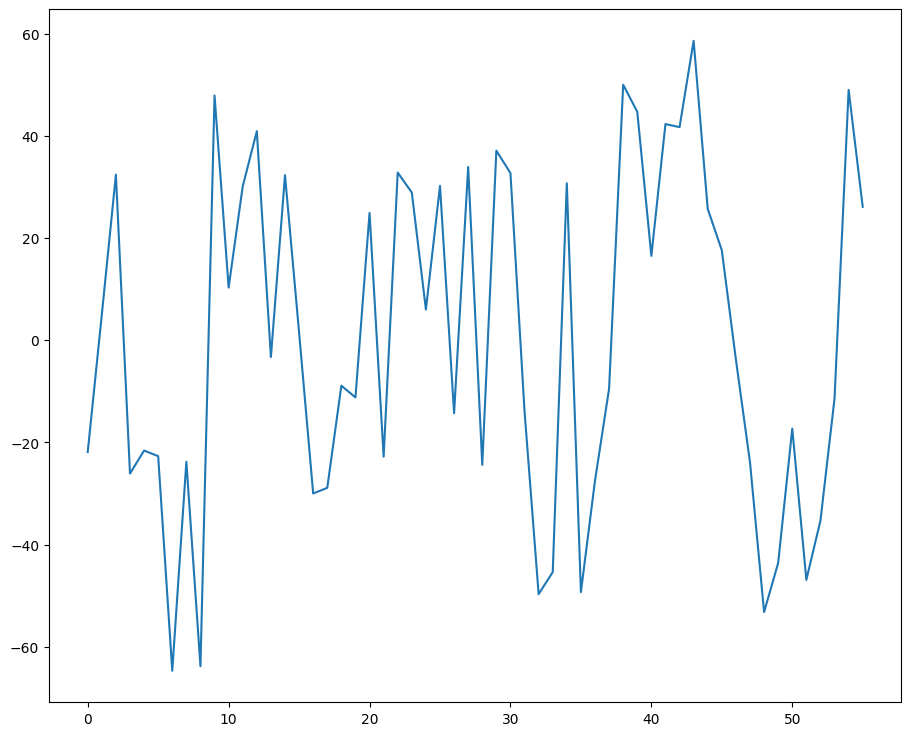

In [25]:
# ряд без сезонности
plt.plot(notseason)

In [26]:
# проверяем ряд без сезонности на стационарность
check_stationary(notseason, 'Снегопад без сезонности')

Тест Дики-Фуллера ряда Снегопад без сезонности :
Test Statistic                 -3.197037
p-value                         0.020157
#Lags Used                     11.000000
Number of Observations Used    44.000000
Critical Value (1%)            -3.588573
Critical Value (5%)            -2.929886
Critical Value (10%)           -2.603185
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


## Преобразование Бокса-Кокса <a class="anchor" id="boxcox"></a>

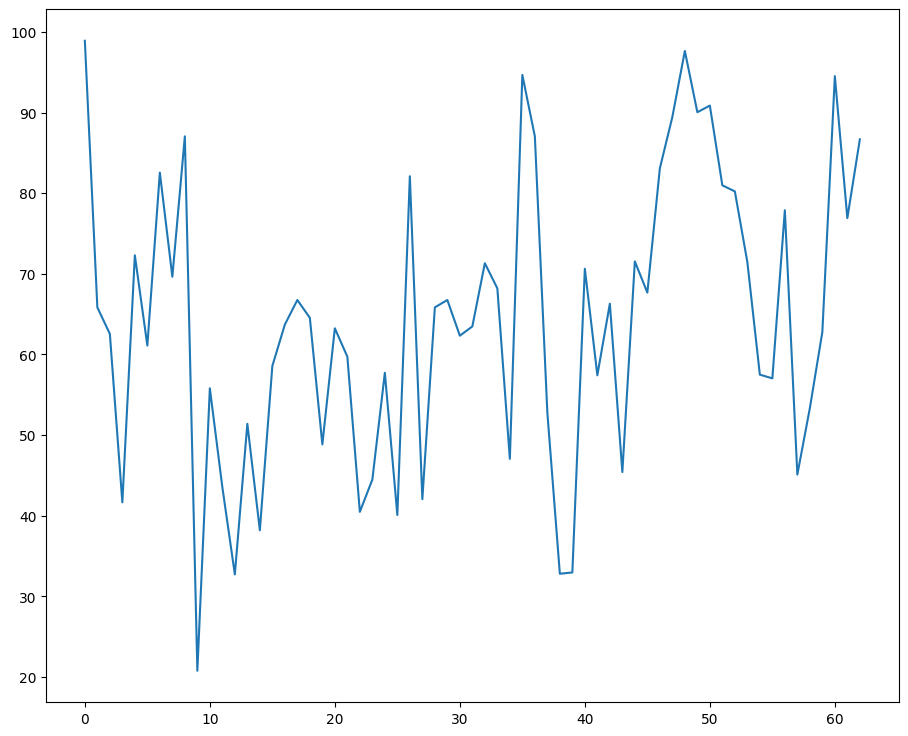

In [28]:
# Преобразование Бокса-Кокса
from scipy.stats import boxcox 

transformed_data, best_lambda = boxcox(df["x"]) 


plt.plot(transformed_data) 

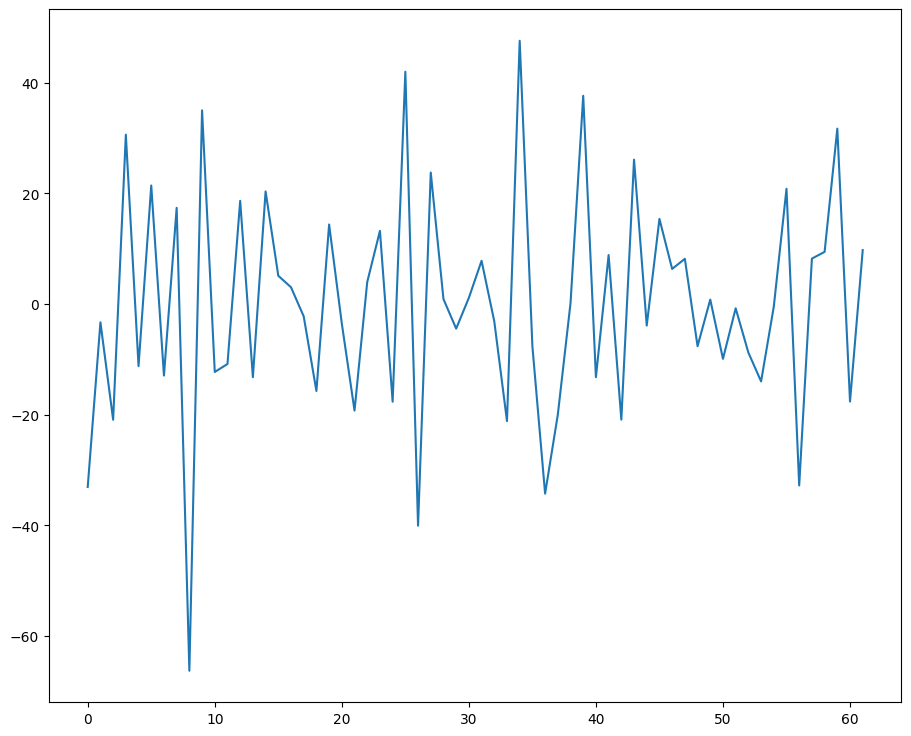

In [33]:
# из преобразованного временного ряда удаляем тренд
pnottrend = []

for i in range(1, len(transformed_data)):
   pnottrend.append(transformed_data[i] - transformed_data[i-1])


plt.plot(pnottrend) 

Удалив тренд из преобразованного Боксом-Коксом ряда, попробуем опять проверить его на стационарность. Что-то изменилось?

In [35]:
# проверяем на стационарность преобразованный БОКСА КОКСА ряд без тренда

check_stationary(pnottrend, 'Снегопад БОКСА КОКСА БЕЗ ТРЕНДА')

Тест Дики-Фуллера ряда Снегопад БОКСА КОКСА БЕЗ ТРЕНДА :
Test Statistic                -1.321209e+01
p-value                        1.042076e-24
#Lags Used                     0.000000e+00
Number of Observations Used    6.100000e+01
Critical Value (1%)           -3.542413e+00
Critical Value (5%)           -2.910236e+00
Critical Value (10%)          -2.592745e+00
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


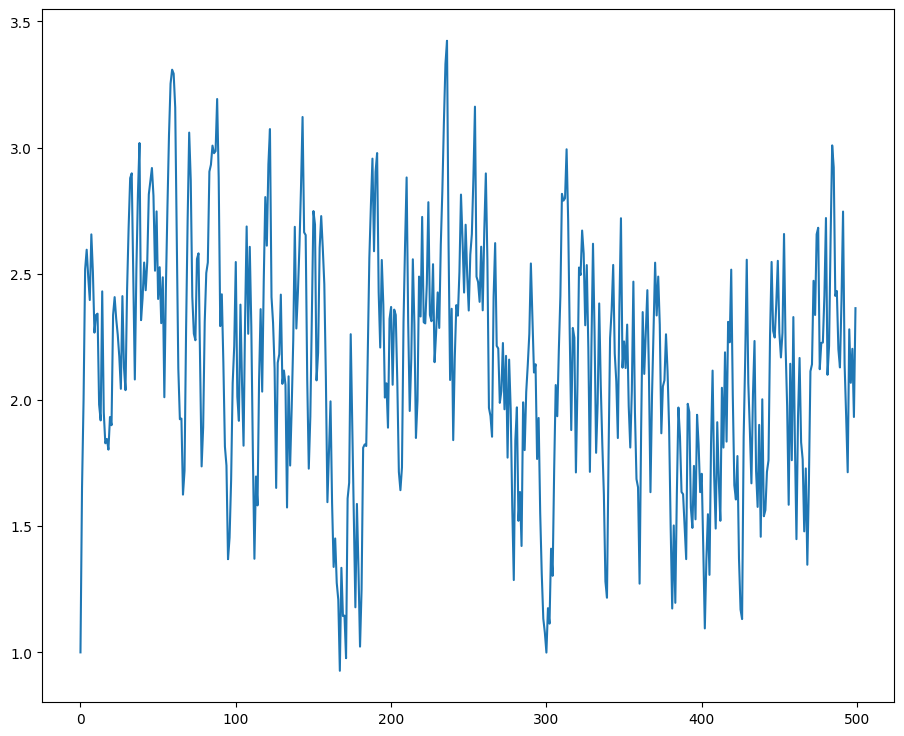

In [36]:
# AR(1)

N = 500

ar1 = [1]

for i in range(1, N):
    ar1.append(0.76 * ar1[i-1] + np.random.random())

plt.plot(ar1)

In [37]:
print(f"standart deviation = {np.std(ar1)}\n mean = {np.mean(ar1)}")

standart deviation = 0.47486224597039256
 mean = 2.1483132711137416


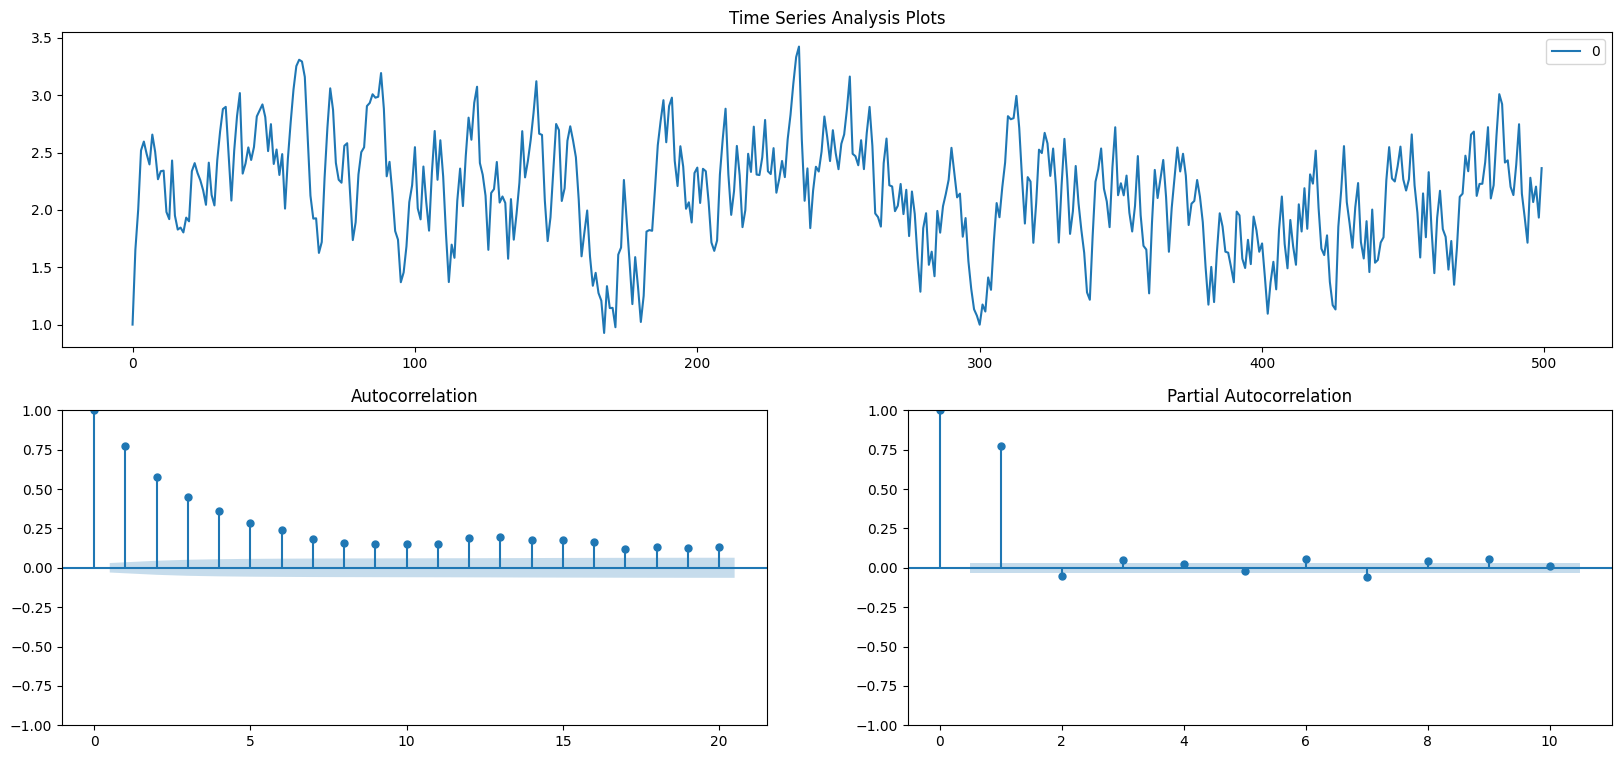

In [38]:
ts = pd.DataFrame(ar1)

fig = plt.figure(figsize=(20, 9))
layout = (2, 2)
ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
acf_ax = plt.subplot2grid(layout, (1, 0))
pacf_ax = plt.subplot2grid(layout, (1, 1))

ts.plot(ax=ts_ax)
ts_ax.set_title('Time Series Analysis Plots')
smt.graphics.plot_acf(ts, lags=20, ax=acf_ax, alpha=0.5)
smt.graphics.plot_pacf(ts, lags=10, ax=pacf_ax, alpha=0.5)
None

standart deviation = 0.39582451524298773
 mean = 0.2784026247507608


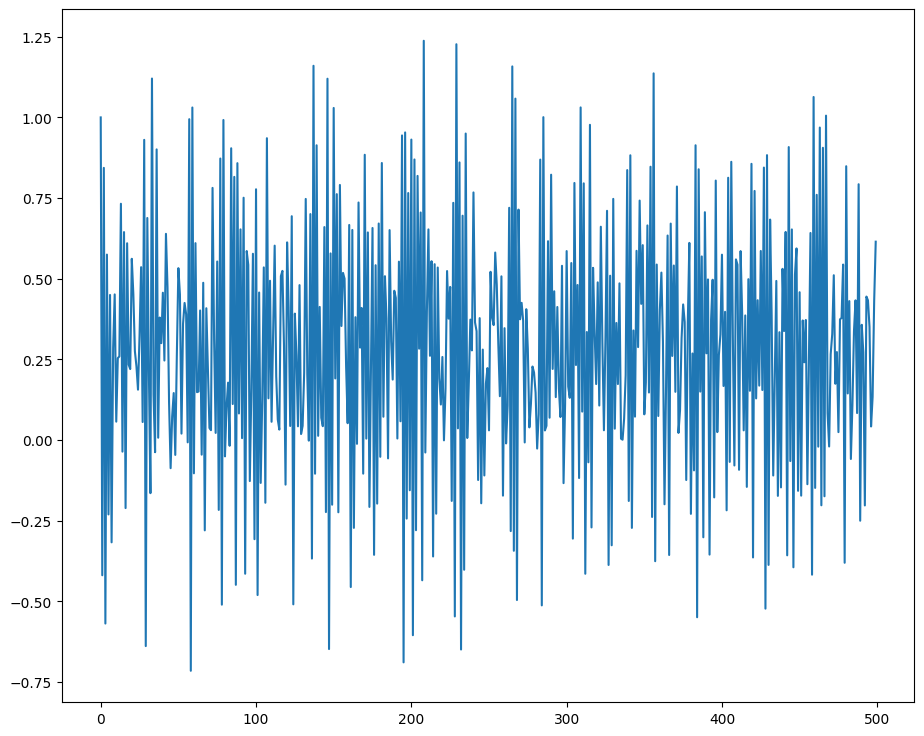

In [39]:
# Создаем другой временной ряд, но уже и с отрицательными значениями
# AR(1)

N = 500

ar2 = [1]

for i in range(1, N):
    ar2.append(- 0.76*ar2[i-1] + np.random.random())

plt.plot(ar2)

print(f"standart deviation = {np.std(ar2)}\n mean = {np.mean(ar2)}")

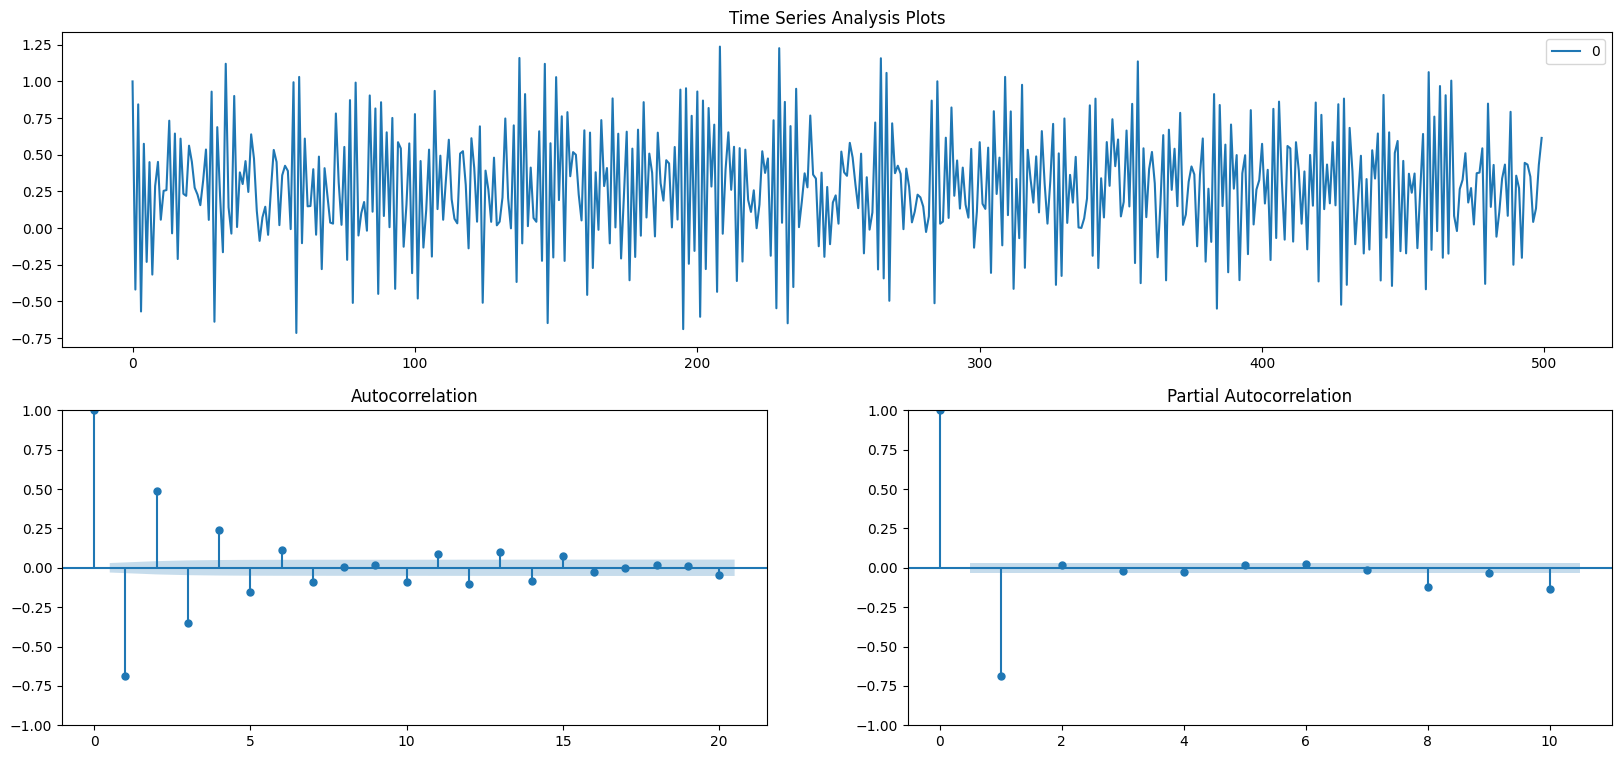

In [40]:
ts = pd.DataFrame(ar2)

fig = plt.figure(figsize=(20, 9))
layout = (2, 2)
ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
acf_ax = plt.subplot2grid(layout, (1, 0))
pacf_ax = plt.subplot2grid(layout, (1, 1))

ts.plot(ax=ts_ax)
ts_ax.set_title('Time Series Analysis Plots')
smt.graphics.plot_acf(ts, lags=20, ax=acf_ax, alpha=0.5)
smt.graphics.plot_pacf(ts, lags=10, ax=pacf_ax, alpha=0.5)
None

In [98]:
df = pd.read_csv('data/Annual snowfall in Buffalo 19101972.csv').set_index("year number")


df['t'] = df.index.values

ln = len(df)

# указываем 'объемы' выборок
train_cutoff = int(round(ln*0.75, 0))
validate_cutoff = int(round(ln*0.90,0))

# делим выборки
train_df = df[df['t'] <= train_cutoff]
validate_df = df[(df['t'] > train_cutoff) & (df['t'] <= validate_cutoff)]
forecast_df = df[df['t'] > validate_cutoff]

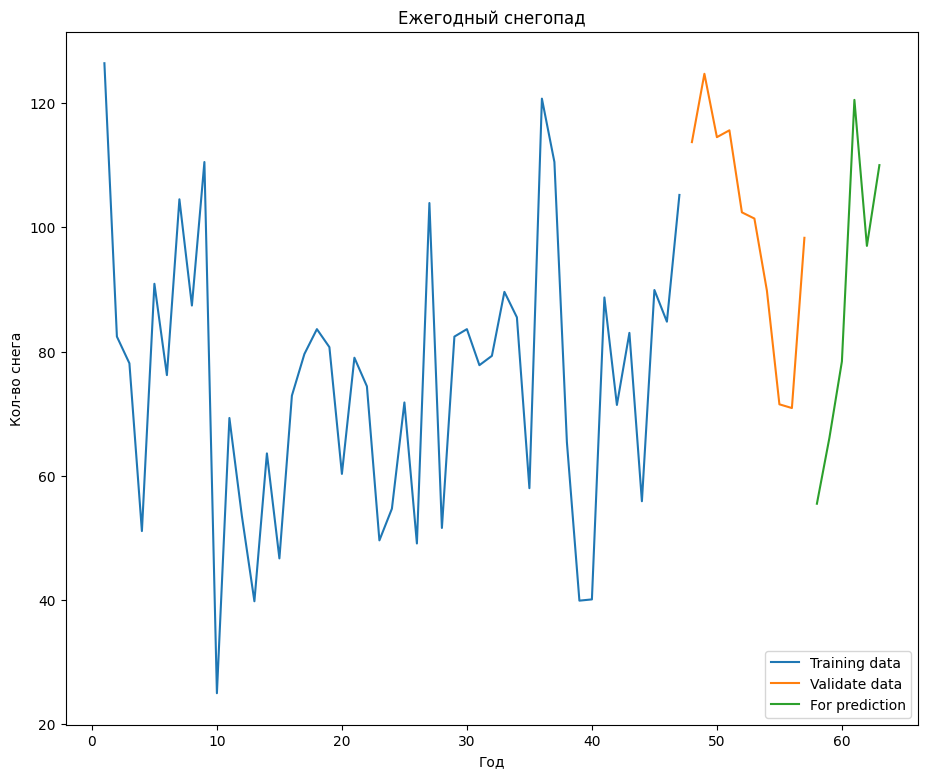

In [52]:
plt.plot(train_df.t, train_df.x, label='Training data')
plt.plot(validate_df.t, validate_df.x, label='Validate data')
plt.plot(forecast_df.t, forecast_df.x, label='For prediction')
plt.legend()
plt.title('Ежегодный снегопад')
plt.ylabel('Кол-во снега')
plt.xlabel('Год')
plt.show()

In [53]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [100]:
mod = AutoReg(df.x, 3, old_names=False)

res = mod.fit()

print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      x   No. Observations:                   63
Model:                     AutoReg(3)   Log Likelihood                -268.483
Method:               Conditional MLE   S.D. of innovations             21.238
Date:                Sat, 25 Nov 2023   AIC                            546.967
Time:                        19:29:34   BIC                            557.438
Sample:                             3   HQIC                           551.063
                                   63                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         45.2499     13.181      3.433      0.001      19.416      71.084
x.L1           0.2789      0.128      2.172      0.030       0.027       0.531
x.L2           0.2767      0.130      2.136      0.0

c:\Users\Gleb\Desktop\psu studies\time_series\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [73]:
# опять обучаем модель, но на этот раз указываем тип ковариационной оценки
res = mod.fit(cov_type="HC0")

# смотрим, что изменилось
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      x   No. Observations:                   63
Model:                     AutoReg(3)   Log Likelihood                -268.483
Method:               Conditional MLE   S.D. of innovations             21.238
Date:                Sat, 25 Nov 2023   AIC                            546.967
Time:                        19:21:27   BIC                            557.438
Sample:                             3   HQIC                           551.063
                                   63                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         45.2499     13.418      3.372      0.001      18.951      71.548
x.L1           0.2789      0.133      2.101      0.036       0.019       0.539
x.L2           0.2767      0.111      2.500      0.0

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


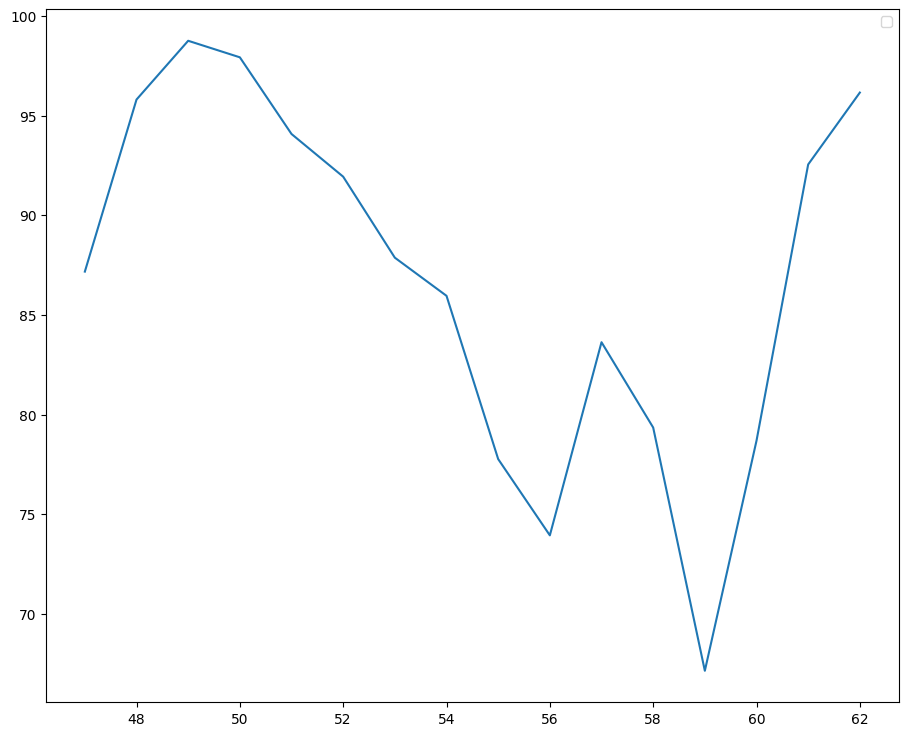

In [101]:
fig = res.plot_predict(train_cutoff)

In [114]:
pred = res.predict(start=0, end=train_cutoff - 1, dynamic=False)
v_pred = res.predict(start=train_cutoff, end=(validate_cutoff) - 1, dynamic=False)
f_pred = res.predict(start=validate_cutoff, end=(forecast_df.t[len(df.t)-1]), dynamic=False)

Отрисовываем их

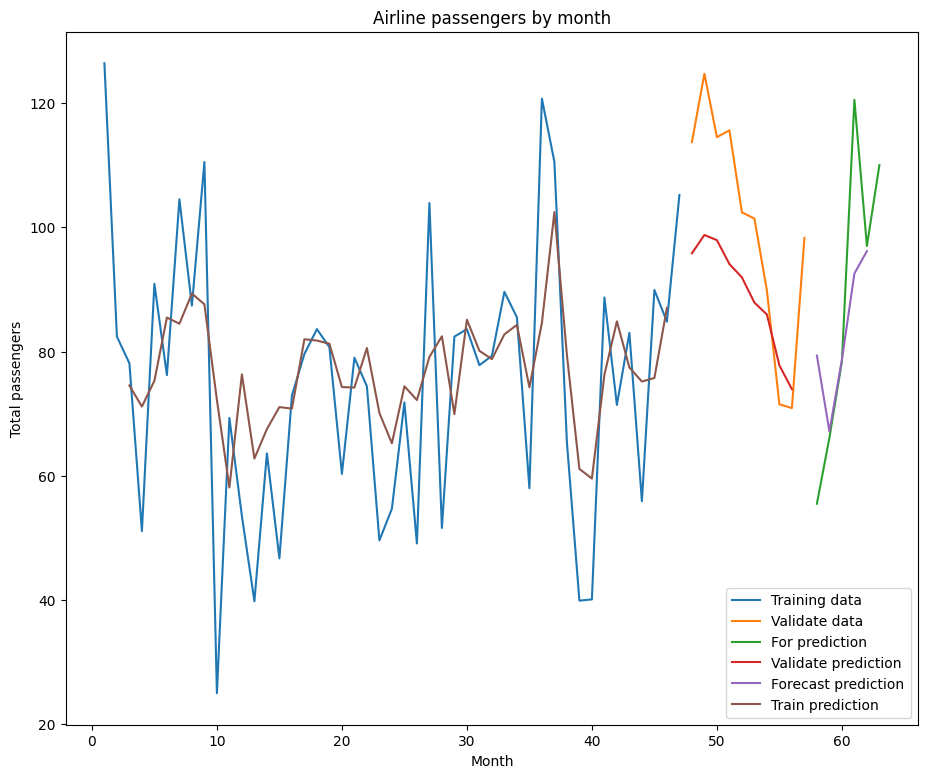

In [116]:
plt.plot(train_df.t, train_df.x, label='Training data')
plt.plot(validate_df.t, validate_df.x, label='Validate data')
plt.plot(forecast_df.t, forecast_df.x, label='For prediction')
plt.plot(validate_df.t, v_pred, label='Validate prediction ')
plt.plot(forecast_df.t, f_pred, label='Forecast prediction')
plt.plot(train_df.t, pred, label='Train prediction')

plt.legend()
plt.title('Airline passengers by month')
plt.ylabel('Total passengers')
plt.xlabel('Month')
plt.show()

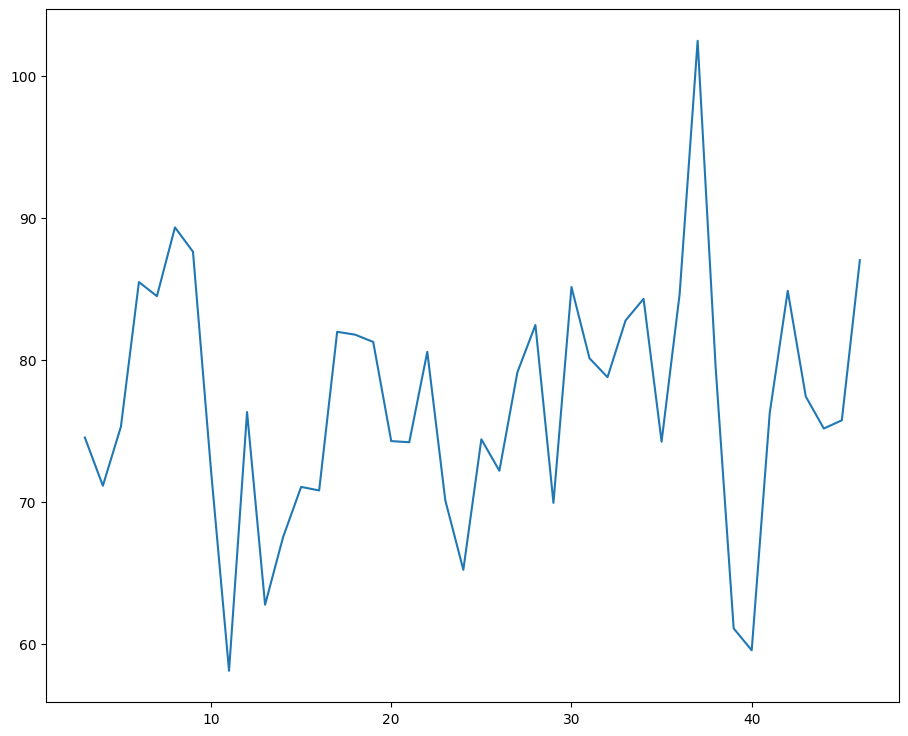

In [117]:
plt.plot(pred)

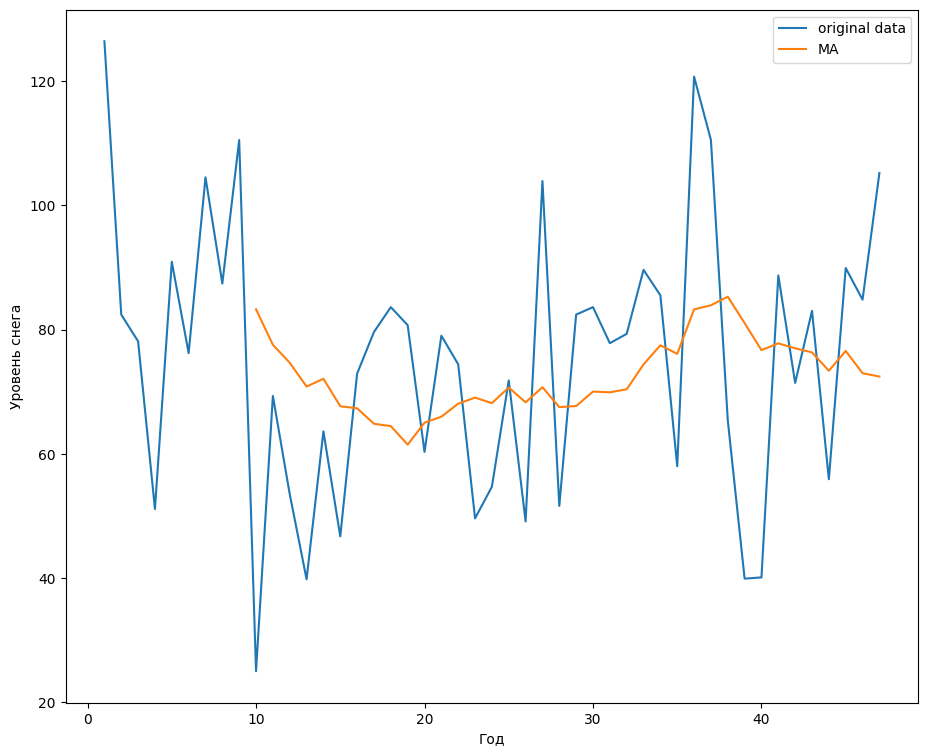

In [118]:
df['t'] = df.index.values

ln = len(df)


train_cutoff = int(round(ln*0.75, 0))
validate_cutoff = int(round(ln*0.90,0))


train_df = df[df['t'] <= train_cutoff]
validate_df = df[(df['t'] > train_cutoff) & (df['t'] <= validate_cutoff)]
forecast_df = df[df['t'] > validate_cutoff]

plt.plot(train_df["t"], train_df["x"], label="original data")
plt.plot(train_df["t"], train_df["x"].rolling(10).mean(), label="MA")
plt.legend()
plt.ylabel('Уровень снега')
plt.xlabel('Год')
plt.show()

* R2- коэффициент детерминации     ​
* MSE (RMSE) – mean squared error – среднеквадратичная ошибка​
* MAE – mean absolute error – средняя абсолютная ошибка​
* MAPE – mean absolute percentage error – средняя абсолютная ошибка в %​
* SMAPE – symmetric mean absolute percentage error – симметричная средняя абсолютная ошибка в %

In [119]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score

In [132]:
print("RMSE:", np.sqrt(mean_squared_error(forecast_df.x, f_pred)))
print("MAPE:", mean_absolute_percentage_error(forecast_df.x, f_pred))
print("MAE:", mean_absolute_error(forecast_df.x, f_pred))
print("R2: ", r2_score(forecast_df.x, f_pred))
smape = np.mean(np.abs(forecast_df.x - f_pred) / (np.abs(forecast_df.x + f_pred) / 2))
print('SMAPE: ', smape)

RMSE: 18.6766136084277
MAPE: 0.15620616250778924
MAE: 13.532212482582542
R2:  0.35587925483711047
SMAPE:  0.154422838433907
